# BTCUSDT dollar bars 数据分析

本笔记本分析以下文件：
- `data\preprocess_data\dollar_bars\BTCUSDT\BTCUSDT_dollar_bars_560k.csv`

目标：
1. 统计每日生成的 bar 数量并绘制分布
2. 统计 dollar bar 生成频率（相邻 bar 时间间隔）分布，并分析极端同时生成情况
3. 分析 dollar bar 成交额分布

说明：所有分布图均使用原始尺度（不取对数）。

## 1. 加载数据与基础清洗

- 读取 CSV
- 解析时间列为 `datetime`
- 按时间排序
- 处理缺失值与重复行
- 展示基础统计

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

# 解析项目根目录（包含 pyproject.toml）
cwd = Path.cwd().resolve()
root = next((p for p in [cwd, *cwd.parents] if (p / "pyproject.toml").exists()), cwd)

file_path = root / "data" / "preprocess_data" / "dollar_bars" / "BTCUSDT" / "BTCUSDT_dollar_bars_560k.csv"

df = pd.read_csv(file_path)
print("rows, cols:", df.shape)
print(df.head(3))
print(df.columns)

# 尝试自动识别时间列
lower_cols = {c.lower(): c for c in df.columns}
possible_time_cols = [
    "timestamp", "time", "datetime", "date", "open_time", "opentime", "bar_time"
 ]

time_col = None
for key in possible_time_cols:
    if key in lower_cols:
        time_col = lower_cols[key]
        break

if time_col is None:
    raise ValueError("未找到时间列，请检查 CSV 列名。")

# 解析时间列（timestamp 同时包含 ms 和 us）
if np.issubdtype(df[time_col].dtype, np.number):
    ts = pd.to_numeric(df[time_col], errors="coerce")
    # 按数量级区分：us (~1e15) 与 ms (~1e12)
    us_mask = ts >= 1e14
    df["dt"] = pd.NaT
    df.loc[us_mask, "dt"] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
    df.loc[~us_mask, "dt"] = pd.to_datetime(ts[~us_mask], unit="ms", errors="coerce")
else:
    df["dt"] = pd.to_datetime(df[time_col], errors="coerce")

print(df[["dt"]].describe())

rows, cols: (492176, 9)
       timestamp     open     high      low    close     volume  \
0  1577836800594  7195.24  7196.25  7180.26  7186.86  78.021917   
1  1577837021668  7186.73  7193.15  7178.20  7192.55  78.098395   
2  1577837402596  7192.45  7193.53  7177.35  7178.92  78.039759   

   dollar_volume  num_trades     close_time  
0  560734.243540         903  1577837021238  
1  561025.765479         797  1577837402430  
2  560643.344726        1221  1577837989865  
Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume',
       'num_trades', 'close_time'],
      dtype='object')
                                  dt
count                         492176
mean   2023-01-01 17:19:41.523781376
min       2020-01-01 00:00:00.594000
25%    2021-07-02 17:50:23.899249920
50%       2023-01-03 14:58:22.660000
75%    2024-07-03 12:17:06.218499840
max       2025-12-31 23:23:22.046369


## 2. 按日统计生成的 bar 数量与频率分布

- 统计每天生成的 bar 数量
- 绘制频率分布图
- 输出分布特征指标（均值、中位数、分位数、偏态）

count    2192.000000
mean      224.532847
std        76.357376
min        58.000000
25%       177.000000
50%       214.000000
75%       264.000000
max       917.000000
Name: bar_count, dtype: float64
skew: 1.175738118960696
quantiles:
 0.05    114.0
0.25    177.0
0.50    214.0
0.75    264.0
0.95    360.0
Name: bar_count, dtype: float64
days in range [144, 288]: 1567/2192 (71.49%)


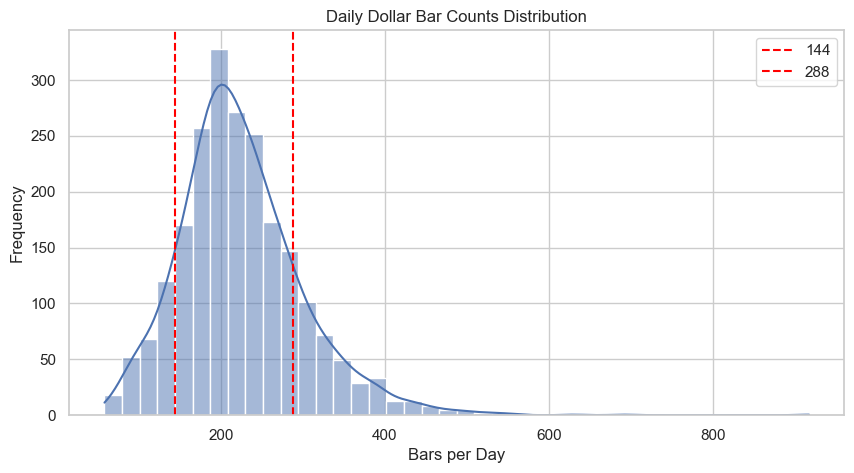

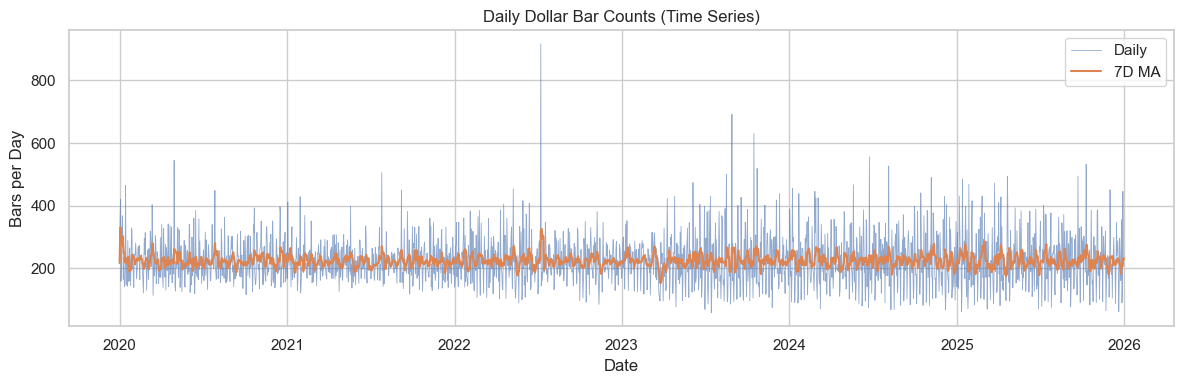

In [19]:
# 每日 bar 数量

df["date"] = df["dt"].dt.date

daily_counts = df.groupby("date").size().rename("bar_count")

print(daily_counts.describe())
print("skew:", daily_counts.skew())
print("quantiles:\n", daily_counts.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# 区间统计
low, high = 144, 288
in_range = daily_counts.between(low, high)
range_count = int(in_range.sum())
total_days = int(len(daily_counts))
print(f"days in range [{low}, {high}]: {range_count}/{total_days} ({range_count/total_days:.2%})")

plt.figure(figsize=(10, 5))
sns.histplot(daily_counts, bins=40, kde=True)
plt.axvline(low, color="red", linestyle="--", label=str(low))
plt.axvline(high, color="red", linestyle="--", label=str(high))
plt.title("Daily Dollar Bar Counts Distribution")
plt.xlabel("Bars per Day")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 时序图（线图 + 7日滚动均值）
daily_ts = daily_counts.sort_index()
rolling_7d = daily_ts.rolling(window=7, min_periods=1).mean()
plt.figure(figsize=(12, 4))
plt.plot(daily_ts.index, daily_ts.values, color="#4C72B0", linewidth=0.6, alpha=0.6, label="Daily")
plt.plot(rolling_7d.index, rolling_7d.values, color="#DD8452", linewidth=1.5, label="7D MA")
plt.title("Daily Dollar Bar Counts (Time Series)")
plt.xlabel("Date")
plt.ylabel("Bars per Day")
plt.legend()
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 观察均值与中位数的差异判断偏态方向。
- 使用 5%/95% 分位数衡量波动区间。
- 偏态系数若显著大于 0，说明存在高频“多 bar 日”。

## 3. dollar bar 生成频率分布与极端同时生成分析

- 计算相邻 bar 的时间间隔
- 绘制生成频率分布图
- 统计相邻时间戳相同的同时生成情况（数量与连续长度）

count    492175.000000
mean        384.795249
std         315.522668
min           0.000000
25%         149.405952
50%         317.900000
75%         543.623000
max       22895.662000
Name: dt, dtype: float64
skew: 3.3703037585565743
quantiles:
 0.05     27.837700
0.25    149.405952
0.50    317.900000
0.75    543.623000
0.95    968.319800
Name: dt, dtype: float64


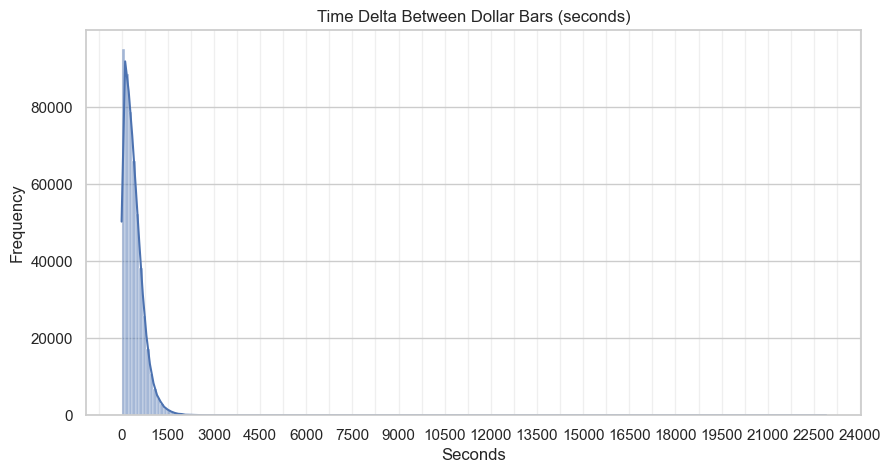

zero intervals count: 117
simultaneous groups: 107
simul group length stats:
 count    107.000000
mean       2.093458
std        0.323096
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: dt, dtype: float64
top 10 simultaneous lengths:
 dt
2020-06-19 02:58:27.622    4
2020-01-02 17:01:07.481    3
2020-01-02 16:47:16.954    3
2020-06-07 07:25:51.703    3
2020-06-07 12:25:36.905    3
2020-08-31 13:19:08.185    3
2020-06-24 07:37:00.349    3
2020-05-09 06:55:29.018    3
2020-06-07 14:05:24.060    3
2020-01-05 22:21:27.290    2
Name: dt, dtype: int64


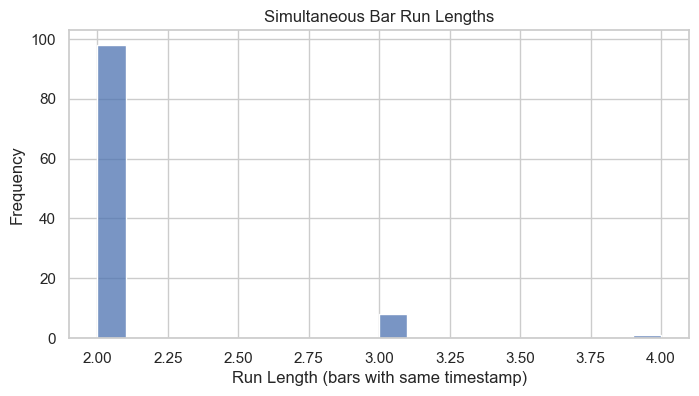

C:\Users\Ithai\AppData\Local\Temp\ipykernel_41528\3640886746.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  delta_hourly = delta_ts.resample("1H").median()


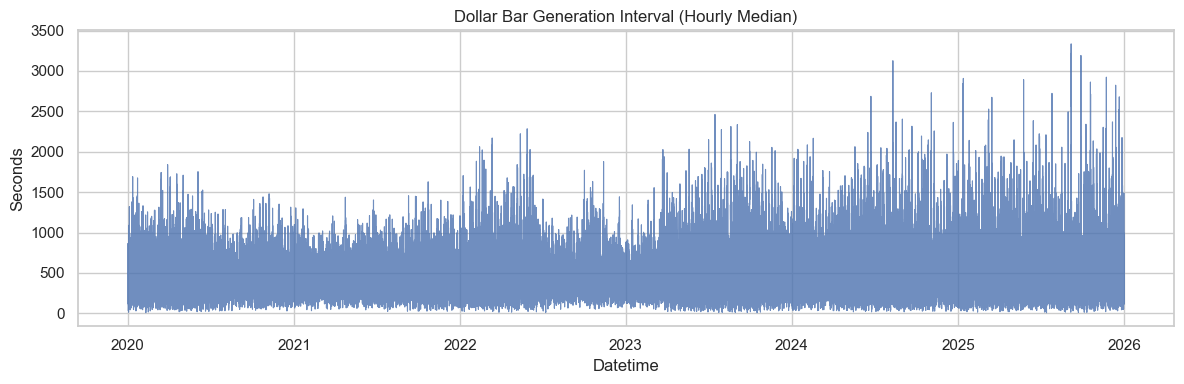

In [20]:
# 相邻 bar 时间间隔（秒）

import matplotlib.ticker as mticker

delta_seconds = df["dt"].diff().dt.total_seconds().dropna()

print(delta_seconds.describe())
print("skew:", delta_seconds.skew())
print("quantiles:\n", delta_seconds.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

plt.figure(figsize=(10, 5))
sns.histplot(delta_seconds, bins=200, kde=True)
plt.title("Time Delta Between Dollar Bars (seconds)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=25))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which="both", axis="x", alpha=0.3)
plt.show()

# 极端情况：相同时间戳的同时生成
same_ts = df["dt"].diff().dt.total_seconds().fillna(1) == 0
zero_intervals = same_ts.sum()

# 计算同一时间戳连续出现的长度
run_lengths = (
    df["dt"]
    .ne(df["dt"].shift())
    .cumsum()
    .groupby(df["dt"])
    .size()
 )

# 仅保留长度 >= 2 的“同时生成”组
simul_groups = run_lengths[run_lengths >= 2]

print("zero intervals count:", int(zero_intervals))
print("simultaneous groups:", int(simul_groups.size))
print("simul group length stats:\n", simul_groups.describe())
print("top 10 simultaneous lengths:\n", simul_groups.sort_values(ascending=False).head(10))

plt.figure(figsize=(8, 4))
if len(simul_groups) > 0:
    sns.histplot(simul_groups, bins=20, kde=False)
    plt.title("Simultaneous Bar Run Lengths")
    plt.xlabel("Run Length (bars with same timestamp)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No simultaneous bars detected.")

# 时序图（按小时中位数，避免过密）
delta_ts = pd.Series(delta_seconds.values, index=df["dt"].iloc[1:])
delta_hourly = delta_ts.resample("1H").median()
plt.figure(figsize=(12, 4))
plt.plot(delta_hourly.index, delta_hourly.values, color="#4C72B0", linewidth=0.8, alpha=0.8)
plt.title("Dollar Bar Generation Interval (Hourly Median)")
plt.xlabel("Datetime")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 间隔分布是否右偏（大量小间隔 + 少量极大间隔）。
- `zero intervals count` 代表相邻两根 bar 同时生成的次数。
- `simul group length stats` 与直方图反映“同时生成”的持续长度分布。

## 4. dollar bar 成交额分布分析

- 选择成交额字段（若不存在则用 `price * volume` 计算）
- 绘制成交额分布图
- 描述分布特征与极端值情况

turnover column: dollar_volume
count    4.921760e+05
mean     1.051988e+07
std      8.217778e+06
min      5.380491e+05
25%      5.097899e+06
50%      8.277730e+06
75%      1.350390e+07
max      7.494514e+07
Name: dollar_volume, dtype: float64
skew: 2.155064938140249
quantiles:
 0.05    2.099604e+06
0.25    5.097899e+06
0.50    8.277730e+06
0.75    1.350390e+07
0.95    2.663499e+07
Name: dollar_volume, dtype: float64


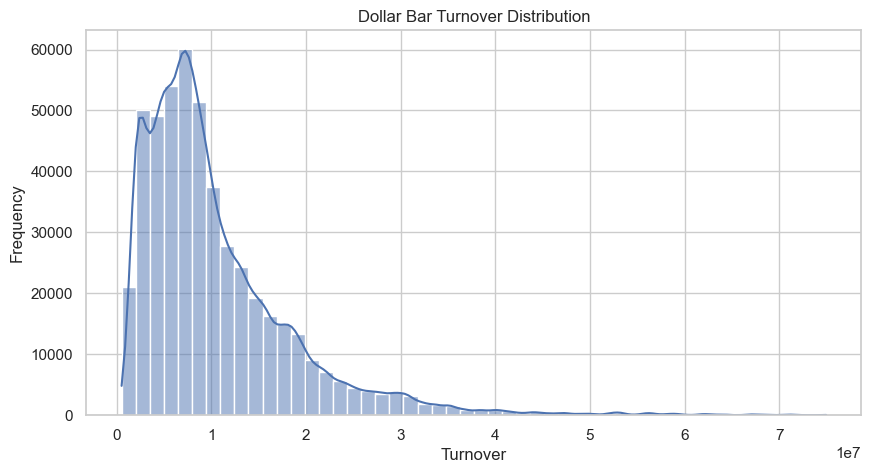

C:\Users\Ithai\AppData\Local\Temp\ipykernel_41528\2032740466.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  turnover_hourly = turnover_ts.resample("1H").median()


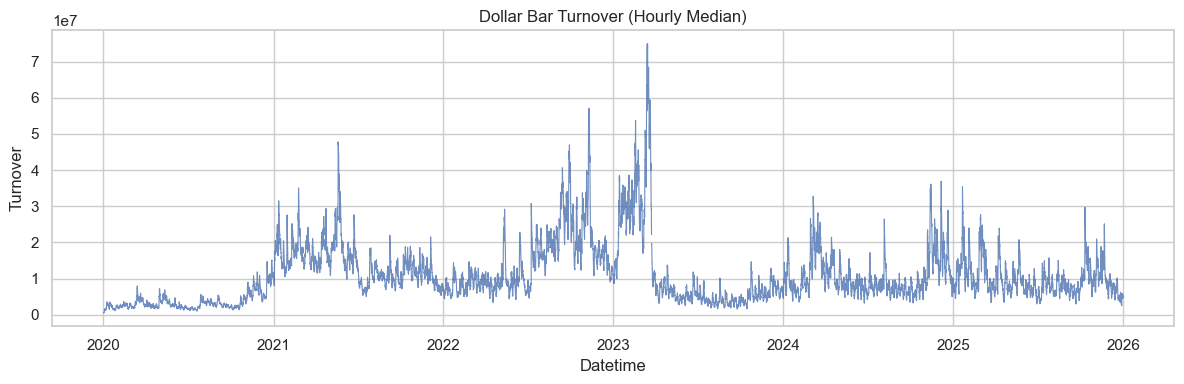

In [21]:
# 选择成交额字段

lower_cols = {c.lower(): c for c in df.columns}

candidate_turnover = [
    "dollar", "dollar_volume", "turnover", "quote_volume", "quote_qty",
    "quote_asset_volume", "amount", "quote_amount"
 ]

turnover_col = None
for key in candidate_turnover:
    if key in lower_cols:
        turnover_col = lower_cols[key]
        break

if turnover_col is None:
    # 退化：用价格 * 成交量
    candidate_price = ["close", "price", "vwap", "avg_price", "avgprice"]
    candidate_volume = ["volume", "qty", "base_volume", "base_qty"]

    price_col = None
    volume_col = None

    for key in candidate_price:
        if key in lower_cols:
            price_col = lower_cols[key]
            break

    for key in candidate_volume:
        if key in lower_cols:
            volume_col = lower_cols[key]
            break

    if price_col is None or volume_col is None:
        raise ValueError("未找到可用于计算成交额的价格或成交量列。")

    df["turnover"] = df[price_col] * df[volume_col]
    turnover_col = "turnover"

print("turnover column:", turnover_col)

turnover_series = df[turnover_col].replace([np.inf, -np.inf], np.nan)
turnover = turnover_series.dropna()

print(turnover.describe())
print("skew:", turnover.skew())
print("quantiles:\n", turnover.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

plt.figure(figsize=(10, 5))
sns.histplot(turnover, bins=50, kde=True)
plt.title("Dollar Bar Turnover Distribution")
plt.xlabel("Turnover")
plt.ylabel("Frequency")
plt.show()

# 时序图（按小时中位数，避免过密）
turnover_ts = turnover_series.copy()
turnover_ts.index = df["dt"]
turnover_hourly = turnover_ts.resample("1H").median()
plt.figure(figsize=(12, 4))
plt.plot(turnover_hourly.index, turnover_hourly.values, color="#4C72B0", linewidth=0.8, alpha=0.8)
plt.title("Dollar Bar Turnover (Hourly Median)")
plt.xlabel("Datetime")
plt.ylabel("Turnover")
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 观察分布是否存在长尾与极端高成交额 bar。
- 结合分位数（如 95% 分位）衡量异常值范围。